In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Define the paths to the folders
pairwise_folder = './extracted/exploring_extreme_parameter_compression_for_pre-trained_language_models/pairwise/'
summarised_folder = './extracted/exploring_extreme_parameter_compression_for_pre-trained_language_models/summarised/'

# Create empty lists to store data
pairwise_data = []
summarised_data = []

# Load pairwise JSONs into a dictionary with filenames as keys (without extensions)
for filename in os.listdir(pairwise_folder):
    if filename.endswith('.json'):
        with open(os.path.join(pairwise_folder, filename)) as f:
            data = json.load(f)
            pairwise_df = pd.DataFrame(data)
            pairwise_data.append((filename.replace('.json', ''), len(pairwise_df.axes[1])))

# Load summarised JSONs into a dictionary with filenames as keys (without extensions)
for filename in os.listdir(summarised_folder):
    if filename.endswith('.json'):
        with open(os.path.join(summarised_folder, filename)) as f:
            data = json.load(f)
            summarized_df = pd.DataFrame(data)
            summarised_data.append((filename.replace('.json', ''), len(summarized_df.axes[1])))

# Convert to Array
summarised_data = np.array(summarised_data, dtype=[('model', 'U20'), ('value', 'i4')])
pairwise_data = np.array(pairwise_data, dtype=[('model_pair', 'U20'), ('value', 'i4')])

In [13]:
# Prepare Dataframe for summarized and pairwise comments for each folder
pairwise_data = []
summarised_data = []

# Define the path to the bigger parent folder
bigger_parent_folder = "./extracted"

# Dictionary to store data for each parent folder
extracted_data = {}

# Walk through only directories directly under the bigger parent folder
for parent_folder in os.listdir(bigger_parent_folder):
    parent_folder_path = os.path.join(bigger_parent_folder, parent_folder)
    
    # Ensure we're only processing directories
    if os.path.isdir(parent_folder_path):
        # Initialize dictionary entry for each parent folder
        extracted_data[parent_folder] = {'pairwise': [], 'summarised': []}
        
        # Check if 'pairwise' folder exists in the current parent folder
        pairwise_folder_path = os.path.join(parent_folder_path, 'pairwise')
        if os.path.isdir(pairwise_folder_path):
            for filename in os.listdir(pairwise_folder_path):
                if filename.endswith('.json'):
                    filepath = os.path.join(pairwise_folder_path, filename)
                    with open(filepath) as f:
                        data = json.load(f)
                        df = pd.DataFrame(data)
                        extracted_data[parent_folder]['pairwise'].append(
                            (filename.replace('.json', ''), len(df.axes[1]))
                        )
        
        # Check if 'summarised' folder exists in the current parent folder
        summarised_folder_path = os.path.join(parent_folder_path, 'summarised')
        if os.path.isdir(summarised_folder_path):
            for filename in os.listdir(summarised_folder_path):
                if filename.endswith('.json'):
                    filepath = os.path.join(summarised_folder_path, filename)
                    with open(filepath) as f:
                        data = json.load(f)
                        df = pd.DataFrame(data)
                        extracted_data[parent_folder]['summarised'].append(
                            (filename.replace('.json', ''), len(df.axes[1]))
                        )

# Output the collected data for each parent folder
print(extracted_data['exploring_extreme_parameter_compression_for_pre-trained_language_models'])

{'pairwise': [('review3-gpt4', 2), ('review1-gemini_pro', 1), ('review2-gpt4', 1), ('review1-gpt4', 0), ('review3-gemini_pro', 2), ('review2-gemini_pro', 2)], 'summarised': [('gemini_pro', 3), ('review1', 2), ('claude_opus', 4), ('review2', 4), ('review3', 5), ('gpt4', 2)]}


In [14]:
def calculate_hit_rates(summarised_data, pairwise_data):
    """ Hit Rate
     |A∩B| |A|

    :param summarised_data: 
    :param pairwise_data: 
    :return: hit_rate: Proportion of overlapping comments to all comments made by models.
    """
    summarised_data = np.array(summarised_data, dtype=[('model', 'U20'), ('value', 'i4')])
    pairwise_data = np.array(pairwise_data, dtype=[('model_pair', 'U20'), ('value', 'i4')])

    model_dict = {model: value for model, value in summarised_data}
    
    ai_models = np.array([model.split('-')[-1] for model in pairwise_data['model_pair']])
    divisors = np.vectorize(model_dict.get)(ai_models)

    # Perform the division on array2's values by the corresponding divisors
    result_values = pairwise_data['value'] / divisors

    # Combine model_pair and result_values into a structured array for the result
    result = np.array(list(zip(pairwise_data['model_pair'], result_values)),
                    dtype=[('model_pair', 'U20'), ('divided_value', 'f4')])
    
    return result


paper_hit_rates = {}

for paper in extracted_data:
    if extracted_data[paper]['summarised'] and extracted_data[paper]['pairwise']:
        hit_rates = calculate_hit_rates(
            extracted_data[paper]['summarised'], 
            extracted_data[paper]['pairwise']
        )
        paper_hit_rates[paper] = hit_rates
    else:
        continue

paper_hit_rates

{'exploring_extreme_parameter_compression_for_pre-trained_language_models': array([('review3-gpt4', 1.        ), ('review1-gemini_pro', 0.33333334),
        ('review2-gpt4', 0.5       ), ('review1-gpt4', 0.        ),
        ('review3-gemini_pro', 0.6666667 ),
        ('review2-gemini_pro', 0.6666667 )],
       dtype=[('model_pair', '<U20'), ('divided_value', '<f4')])}

In [15]:
def calculate_sso_coefficients(summarised_data, pairwise_data):
    """ Szymkiewicz–Simpson Overlap Coefficient.
     |A ∩ B| / min(|A|, |B|)
     
    :param summarised_data: 
    :param pairwise_data: 
    :return: sso_coefficients: Proportion of matching comments to the minimum of comments made. 
    """
    
    # Get Individual vs. Overlapping Counts
    individual_comments = np.array(summarised_data, dtype=[('model', 'U20'), ('value', 'i4')])
    overlapping_comments = np.array(pairwise_data, dtype=[('model_pair', 'U20'), ('value', 'i4')])
    individual_dict = {model: value for model, value in individual_comments}
    
    # Get Matches
    model_names = np.array([model.split('-')[-1] for model in overlapping_comments['model_pair']])
    reviewer_names = np.array([model.split('-')[0] for model in overlapping_comments['model_pair']])
    
    # Get Number of available Comments from either 
    model_counts = np.vectorize(individual_dict.get)(model_names)
    reviewer_counts = np.vectorize(individual_dict.get)(reviewer_names)
    minimum_counts = np.min([model_counts, reviewer_counts], axis=0)

    # Perform the division on array2's values by the corresponding divisors
    sso_coefficients = overlapping_comments['value'] / minimum_counts

    # Combine model_pair and result_values into a structured array for the result
    result = np.array(list(zip(overlapping_comments['model_pair'], sso_coefficients)),
                    dtype=[('model_pair', 'U20'), ('divided_value', 'f4')])

    return result

paper_sso_coefficients = {}

for paper in extracted_data:
    if extracted_data[paper]['summarised'] and extracted_data[paper]['pairwise']:
        sso_coefficients = calculate_sso_coefficients(
            extracted_data[paper]['summarised'], 
            extracted_data[paper]['pairwise']
        )
        paper_sso_coefficients[paper] = sso_coefficients
    else:
        continue

paper_sso_coefficients

{'exploring_extreme_parameter_compression_for_pre-trained_language_models': array([('review3-gpt4', 1.       ), ('review1-gemini_pro', 0.5      ),
        ('review2-gpt4', 0.5      ), ('review1-gpt4', 0.       ),
        ('review3-gemini_pro', 0.6666667),
        ('review2-gemini_pro', 0.6666667)],
       dtype=[('model_pair', '<U20'), ('divided_value', '<f4')])}

In [19]:
def calculate_jaccard_indices(summarised_data, pairwise_data):
    """ Jaccard Index 
    
    |A ∩ B| / |A∪B|
    
    :param summarised_data: 
    :param pairwise_data: 
    :return: jaccard_index: Proportion of matching comments to the total amount of comments made (exluding duplicates). 
    """
    
    # Get Individual vs. Overlapping Counts
    individual_comments = np.array(summarised_data, dtype=[('model', 'U20'), ('value', 'i4')])
    overlapping_comments = np.array(pairwise_data, dtype=[('model_pair', 'U20'), ('value', 'i4')])
    individual_dict = {model: value for model, value in individual_comments}
    
    # Get Matches
    model_names = np.array([model.split('-')[-1] for model in overlapping_comments['model_pair']])
    reviewer_names = np.array([model.split('-')[0] for model in overlapping_comments['model_pair']])
    
    # Get Number of available Comments from either 
    model_counts = np.vectorize(individual_dict.get)(model_names)
    reviewer_counts = np.vectorize(individual_dict.get)(reviewer_names)
    total_counts = np.sum([model_counts, reviewer_counts], axis=0)
    union_counts = total_counts - overlapping_comments['value']

    # Perform the division on array2's values by the corresponding divisors
    jaccard_indices = overlapping_comments['value'] / union_counts

    # Combine model_pair and result_values into a structured array for the result
    result = np.array(list(zip(overlapping_comments['model_pair'], jaccard_indices)),
                    dtype=[('model_pair', 'U20'), ('divided_value', 'f4')])

    return result

paper_jaccard_indices = {}

for paper in extracted_data:
    if extracted_data[paper]['summarised'] and extracted_data[paper]['pairwise']:
        jaccard_indices = calculate_jaccard_indices(
            extracted_data[paper]['summarised'], 
            extracted_data[paper]['pairwise']
        )
        paper_jaccard_indices[paper] = jaccard_indices
    else:
        continue

paper_jaccard_indices

{'exploring_extreme_parameter_compression_for_pre-trained_language_models': array([('review3-gpt4', 0.4       ), ('review1-gemini_pro', 0.25      ),
        ('review2-gpt4', 0.2       ), ('review1-gpt4', 0.        ),
        ('review3-gemini_pro', 0.33333334),
        ('review2-gemini_pro', 0.4       )],
       dtype=[('model_pair', '<U20'), ('divided_value', '<f4')])}

In [18]:
def calculate_sd_coefficient(summarised_data, pairwise_data):
    """ Sørensen–Dice Coefficient
     2|A∩B| |A| + |B|
    
    :param summarised_data: 
    :param pairwise_data: 
    :return: sd_coefficient: Proportion of twice the matching comments in respect to the sum of all comments made (including duplicates).
    """
    
    # Get Individual vs. Overlapping Counts
    individual_comments = np.array(summarised_data, dtype=[('model', 'U20'), ('value', 'i4')])
    overlapping_comments = np.array(pairwise_data, dtype=[('model_pair', 'U20'), ('value', 'i4')])
    individual_dict = {model: value for model, value in individual_comments}
    
    # Get Matches
    model_names = np.array([model.split('-')[-1] for model in overlapping_comments['model_pair']])
    reviewer_names = np.array([model.split('-')[0] for model in overlapping_comments['model_pair']])
    
    # Get Number of available Comments from either 
    model_counts = np.vectorize(individual_dict.get)(model_names)
    reviewer_counts = np.vectorize(individual_dict.get)(reviewer_names)
    total_counts = np.sum([model_counts, reviewer_counts], axis=0)

    # Perform the division on array2's values by the corresponding divisors
    jaccard_indices = (2 * overlapping_comments['value']) / total_counts

    # Combine model_pair and result_values into a structured array for the result
    result = np.array(list(zip(overlapping_comments['model_pair'], jaccard_indices)),
                    dtype=[('model_pair', 'U20'), ('divided_value', 'f4')])

    return result

paper_sd_coefficients = {}

for paper in extracted_data:
    if extracted_data[paper]['summarised'] and extracted_data[paper]['pairwise']:
        sd_coefficients = calculate_sd_coefficient(
            extracted_data[paper]['summarised'], 
            extracted_data[paper]['pairwise']
        )
        paper_sd_coefficients[paper] = sd_coefficients
    else:
        continue

paper_sd_coefficients

{'exploring_extreme_parameter_compression_for_pre-trained_language_models': array([('review3-gpt4', 0.5714286 ), ('review1-gemini_pro', 0.4       ),
        ('review2-gpt4', 0.33333334), ('review1-gpt4', 0.        ),
        ('review3-gemini_pro', 0.5       ),
        ('review2-gemini_pro', 0.5714286 )],
       dtype=[('model_pair', '<U20'), ('divided_value', '<f4')])}

In [26]:
# Combine all dictionaries
all_metrics = {}

# Assuming the paper names are consistent across all dictionaries
for paper_name in paper_hit_rates.keys():
    # Initialize the nested dictionary for each paper
    all_metrics[paper_name] = {}
    
    # Populate hit_rate values
    for model_pair, hit_rate in paper_hit_rates[paper_name]:
        all_metrics[paper_name][model_pair] = {'hit_rate': hit_rate}
    
    # Populate sso_coefficient values
    for model_pair, sso in paper_sso_coefficients[paper_name]:
        all_metrics[paper_name][model_pair]['sso_coefficient'] = sso
    
    # Populate jaccard_index values
    for model_pair, jaccard in paper_jaccard_indices[paper_name]:
        all_metrics[paper_name][model_pair]['jaccard_index'] = jaccard
    
    # Populate sd_coefficient values
    for model_pair, sd in paper_sd_coefficients[paper_name]:
        all_metrics[paper_name][model_pair]['sd_coefficient'] = sd

all_metrics

{'exploring_extreme_parameter_compression_for_pre-trained_language_models': {'review3-gpt4': {'hit_rate': 1.0,
   'sso_coefficient': 1.0,
   'jaccard_index': 0.4,
   'sd_coefficient': 0.5714286},
  'review1-gemini_pro': {'hit_rate': 0.33333334,
   'sso_coefficient': 0.5,
   'jaccard_index': 0.25,
   'sd_coefficient': 0.4},
  'review2-gpt4': {'hit_rate': 0.5,
   'sso_coefficient': 0.5,
   'jaccard_index': 0.2,
   'sd_coefficient': 0.33333334},
  'review1-gpt4': {'hit_rate': 0.0,
   'sso_coefficient': 0.0,
   'jaccard_index': 0.0,
   'sd_coefficient': 0.0},
  'review3-gemini_pro': {'hit_rate': 0.6666667,
   'sso_coefficient': 0.6666667,
   'jaccard_index': 0.33333334,
   'sd_coefficient': 0.5},
  'review2-gemini_pro': {'hit_rate': 0.6666667,
   'sso_coefficient': 0.6666667,
   'jaccard_index': 0.4,
   'sd_coefficient': 0.5714286}}}

In [ ]:
# Initialize a dictionary to hold the sums and counts for each metric
metrics_sums = {}
metrics_counts = {}

# Sum up each metric for each model and count occurrences
for paper, reviews in all_metrics.items():
    for model_pair, metrics in reviews.items():
        if model_pair not in metrics_sums:
            metrics_sums[model_pair] = {'hit_rate': 0, 'sso_coefficient': 0, 'jaccard_index': 0, 'sd_coefficient': 0}
            metrics_counts[model_pair] = 0
        # Add each metric to the sum
        for metric, value in metrics.items():
            metrics_sums[model_pair][metric] += value
        metrics_counts[model_pair] += 1

# Calculate the average for each metric per model
averages = {model_pair: {metric: metrics_sums[model_pair][metric] / metrics_counts[model_pair]
                         for metric in metrics_sums[model_pair]}
            for model_pair in metrics_sums}

# Plot the results
metric_names = list(next(iter(averages.values())).keys())  # Get metric names from any model
num_metrics = len(metric_names)
model_pairs = list(averages.keys())
num_models = len(model_pairs)

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.15  # Width of each bar
x = np.arange(num_metrics)  # x locations for the groups of metrics

# Plot each model's metrics
for i, model_pair in enumerate(model_pairs):
    metric_values = [averages[model_pair][metric] for metric in metric_names]
    ax.bar(x + i * width, metric_values, width, label=model_pair)

# Add labels and formatting
ax.set_xlabel('Metrics')
ax.set_ylabel('Average Values')
ax.set_title('Average Metric Values per Model')
ax.set_xticks(x + width * (num_models - 1) / 2)
ax.set_xticklabels(metric_names)
ax.legend(title='Model Pair')
plt.tight_layout()
plt.show()

In [15]:
def plot_average_hit_rate(data, model_key):
    # Extract the model pairs and values
    records = data[model_key]
    
    # Separate hit rates for gemini_pro and gpt4
    gemini_pro_values = [record['divided_value'] for record in records if 'gemini_pro' in record['model_pair']]
    gpt4_values = [record['divided_value'] for record in records if 'gpt4' in record['model_pair']]
    
    # Calculate average hit rates
    avg_gemini_pro = np.mean(gemini_pro_values) if gemini_pro_values else 0
    avg_gpt4 = np.mean(gpt4_values) if gpt4_values else 0
    
    # Plot bar graph
    models = ['gemini_pro', 'gpt4']
    averages = [avg_gemini_pro, avg_gpt4]
    
    plt.figure(figsize=(8, 5))
    plt.bar(models, averages, color=['blue', 'green'])
    plt.xlabel('AI Model')
    plt.ylabel('Average Hit Rate')
    plt.title(f'Average Hit Rate for Reviews - {model_key}')
    plt.ylim(0, 1)  # assuming hit rate is between 0 and 1
    
    # Display the average values on the bars
    for i, avg in enumerate(averages):
        plt.text(i, avg + 0.05, f"{avg:.2f}", ha='center', fontsize=12)
    
    plt.show()

def plot_average_hit_rate_across_papers(data):
    # Lists to aggregate hit rates for gemini_pro and gpt4 across all papers
    gemini_pro_values = []
    gpt4_values = []
    
    # Iterate over each paper's data
    for _, records in data.items():
        # Collect values for gemini_pro and gpt4
        gemini_pro_values.extend([record['divided_value'] for record in records if 'gemini_pro' in record['model_pair']])
        gpt4_values.extend([record['divided_value'] for record in records if 'gpt4' in record['model_pair']])
    
    # Calculate average hit rates across all papers
    avg_gemini_pro = np.mean(gemini_pro_values) * 100 if gemini_pro_values else 0  # Multiply by 100
    avg_gpt4 = np.mean(gpt4_values) * 100 if gpt4_values else 0  # Multiply by 100
    
    # Plot bar graph
    models = ['gemini_pro', 'gpt4']
    averages = [avg_gemini_pro, avg_gpt4]
    
    plt.figure(figsize=(8, 5))
    plt.bar(models, averages, color=['blue', 'green'])
    plt.xlabel('AI Model')
    plt.ylabel('Average Hit Rate (%)')
    plt.title('Retrospective overlap analysis of ML models across all papers')
    plt.ylim(0, 100)  # y-axis from 0 to 100
    
    # Display the average values on the bars
    for i, avg in enumerate(averages):
        plt.text(i, avg + 2, f"{avg:.2f}%", ha='center', fontsize=12)
    
    plt.show()


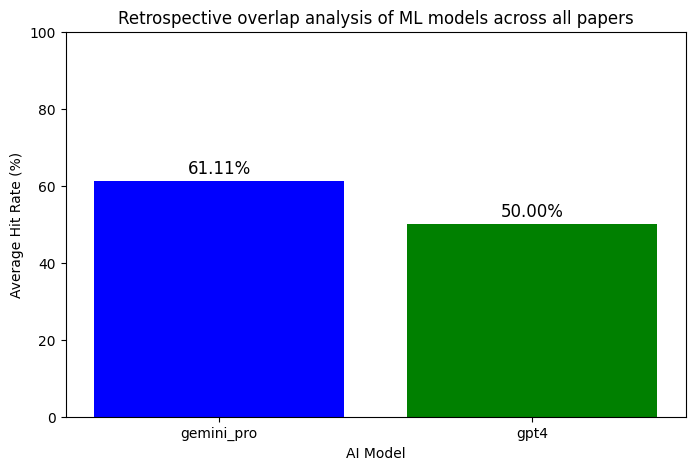

In [16]:
plot_average_hit_rate_across_papers(paper_sso_coefficients)